In [1]:
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G

from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import glob
import pandas as pd
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
from shapey import Box
import popsims
from scipy import stats
from scipy.signal import find_peaks

path_plot = '/users/caganze/research/stellarstreams/figures/stream/'
path_data = '/users/caganze/research/stellarstreams/data/stream/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


In [2]:
#coords standards
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')

#potential and hamiltonian
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)

galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)

In [3]:
def resample_stream(st, mag_limit, center, box):
    
    x0=((st.x.value-gap_center[0])+center[0])
    y0=((st.y.value-gap_center[1])+center[1])
    
    choose=np.random.choice(np.arange(len(x0)), NSAMPLES_STREAM[mag_limit])
    
    selected=box.select(np.array([x0[choose], y0[choose]]))
    x=selected[0]
    y=selected[1]
    
    return  [x,  y]
                    
        
def transform_to_phi_coordinates(st, end_points=None):
    stream_p=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.z.unit,
                          vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    #transform to stream coordinate frame 
    stream_c = stream_p.to_coord_frame(astro_coord.ICRS)
    
    if end_points is  None:
        min_ra_id= np.argmin(stream_c.ra.degree)
        max_ra_id=np.argmax(stream_c.ra.degree)
        
        end_points=astro_coord.SkyCoord(ra=[stream_c.ra.degree[min_ra_id], \
                                           stream_c.ra.degree[max_ra_id]]*u.deg,
                            dec=[stream_c.dec.degree[min_ra_id], \
                                           stream_c.dec.degree[max_ra_id]]*u.deg)

    fr = gc.GreatCircleICRSFrame.from_endpoints(end_points[0], end_points[1],
                                            ra0=np.nanmean(stream_c.ra))
    return {'icrs': stream_c, 'great_circ': stream_c.transform_to(fr)}


def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont

def evolve_stream_in_time(st, time, dt=1*u.Myr, progenitor=False):
    time_dict={'t1': 0*u.Myr, 't2': time, 'dt': dt}
    #make a phase space position objec
    stpos=None
    if progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x.value, st.y.value, st.z.value])*st.x.unit,
                              vel=np.array([st.v_x.value, st.v_y.value, st.v_z.value])*st.v_z.unit)
    if not progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.x.unit,
                              vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    final_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(stpos,  **time_dict)
    
    #integrate in time
    new_stream_coord=SkyCoord(x=final_stream_orbit.x[-1], y=final_stream_orbit.y[-1],
                       z= final_stream_orbit.z[-1], v_x=final_stream_orbit.v_x[-1],\
                       v_y=final_stream_orbit.v_y[-1], v_z=final_stream_orbit.v_z[-1],\
                       frame=galcen_frame)
    return new_stream_coord

def read_orbit_file(filename):
    return np.load(path_data+'/{}'.format(filename), allow_pickle=True)


def make_density_plot(values, ax, cmap=plt.cm.coolwarm, bins=100, hist=False):
    if not hist:
        kernel = stats.gaussian_kde(values)
        x, y=np.meshgrid(np.linspace(values[0].min()-0.9, values[0].max(), bins), \
                         np.linspace(values[1].min()-0.9, values[1].max(), bins))
        positions = np.vstack([x.ravel(), y.ravel()])
        Z = np.reshape(kernel(positions).T, x.shape)
        #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
        ax.scatter(positions[0], positions[1], c=kernel(positions), cmap=cmap)
    if hist:
        _= ax.hist2d(values[0], values[1], cmap=cmap, bins=bins)
        
    
def findPeak(arr, n) :

    # first or last element is peak element
    if (n == 1) :
      return 0
    if (arr[0] >= arr[1]) :
        return 0
    if (arr[n - 1] >= arr[n - 2]) :
        return n - 1
 
    # check for every other element
    for i in range(1, n - 1) :
 
        # check if the neighbors are smaller
        if (arr[i] >= arr[i - 1] and arr[i] >= arr[i + 1]) :
            return i

In [4]:
vhalo=50
mstream=1
mhalo='1.00e+07'
mhalos=['1.00e+06', '3.00e+06', '5.00e+06', '7.00e+06', '1.00e+07', '5.00e+07']

In [5]:
#%matplotlib notebook

In [6]:
#SADSDF

[Text(0.5, 1.0, 'N=10,000')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


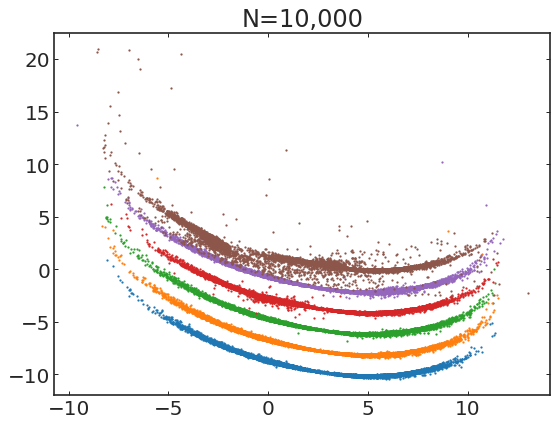

In [7]:
fig, ax=plt.subplots()
for idx in range(len(mhalos)):
    filenames=np.array(glob.glob(path_data+'/*mass_{}_times_pal5_rgc10*_mhalo{}*vhalo{}_*.npy'.format(mstream,mhalos[idx], vhalo)))
    st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
    evolved_st= evolve_stream_in_time(st, 0.5*u.Gyr)
    ax.scatter(evolved_st.y,evolved_st.z.value+2*idx, s=1)
ax.set(title='N=10,000')

[Text(0.5, 1.0, 'N=254')]

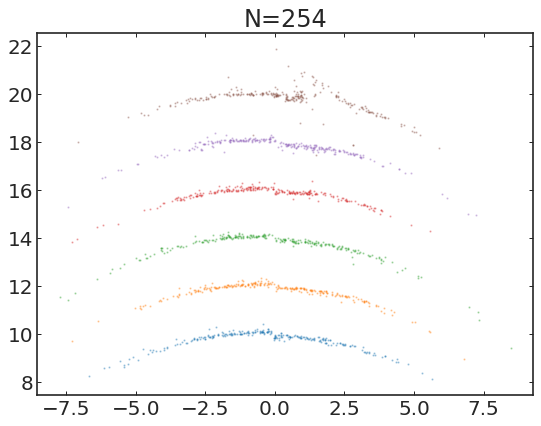

In [8]:
#resample to n=254
fig, ax=plt.subplots()
for idx in range(len(mhalos)):
    filenames=np.array(glob.glob(path_data+'/*mass_{}_times_pal5_rgc10*_mhalo{}*vhalo{}_*.npy'.format(mstream,mhalos[idx], vhalo)))
    st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
    evolved_st= evolve_stream_in_time(st, .5*u.Gyr)
    choices= np.random.choice(len(evolved_st), 254)
    ax.scatter(st.y[choices], st.z.value[choices]+2*idx, s=1, alpha=0.3)
    
ax.set(title='N=254')
    

[Text(0.5, 1.0, 'N=2000')]

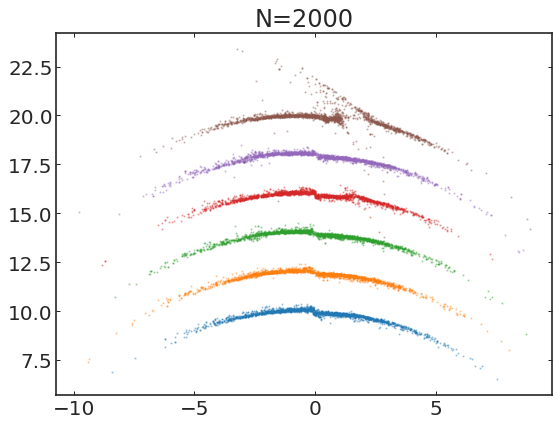

In [9]:
#resample to n=2000
fig, ax=plt.subplots()
for idx in range(len(mhalos)):
    filenames=np.array(glob.glob(path_data+'/*mass_{}_times_pal5_rgc10*_mhalo{}*vhalo{}_*.npy'.format(mstream,mhalos[idx], vhalo)))
    st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
    evolved_st= evolve_stream_in_time(st, .5*u.Gyr)
    choices= np.random.choice(len(evolved_st), 2000)
    ax.scatter(st.y[choices], st.z.value[choices]+2*idx, s=1, alpha=0.3)
    
ax.set(title='N=2000')

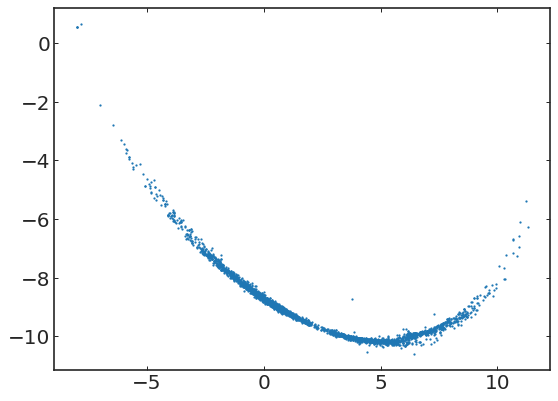

In [10]:
mhalo='1.00e+07'
filenames=np.array(glob.glob(path_data+'/*mass_{}_times_pal5_rgc10*_mhalo{}*vhalo{}_*.npy'.format(mstream,mhalo, vhalo)))
st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
evolved_st= evolve_stream_in_time(st, 0.5*u.Gyr)
fig, ax=plt.subplots()
choices=np.random.choice(len(evolved_st.x), 3000)
ax.scatter(evolved_st.y[choices],evolved_st.z.value[choices], s=1)

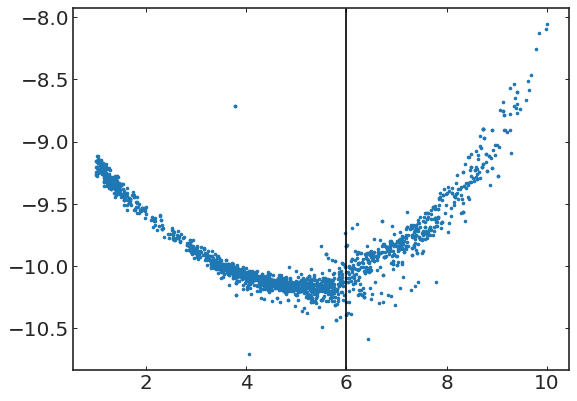

In [11]:
#st_trans=transform_to_phi_coordinates(st)
x=evolved_st.y.value
y=evolved_st.z.value
mask=np.logical_and(x<10 , x>1)
x=x[mask]
y=y[mask]
choices= np.random.choice(range(len(x)), 2000)
x=x[choices]
y=y[choices]
fig, ax=plt.subplots()
ax.scatter(x, y, s=5)
ax.axvline(6, color='k')

In [12]:
np.nanmin(x), np.nanmax(x)

(1.0030018950523008, 9.996007546738742)

In [13]:
#iimplet a a KL divergence to measure how different the 
def kernel_density(x, bw_method=0.01):
    return stats.gaussian_kde(x, bw_method= bw_method)


def return_estimated_2d_kernel(x, y, bw_method=0.1, xmin=x.min(), xmax=x.max(), ymin=y.min(), ymax=y.max()):
    values = np.vstack([x, y])
    k=kernel_density(values, bw_method=bw_method)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    grid = np.vstack([X.ravel(), Y.ravel()])
    kde=k(grid)
    Z = np.reshape(kde.T, X.shape)
    return { 'grid': grid, 'kde':Z}


def return_estimated_1d_kernel(x,bw_method=0.1, xmin=x.min(), xmax=x.max()):
    k=kernel_density(x, bw_method=bw_method)
    grid = np.linspace(xmin, xmax, 5000)
    kde=k(grid)
    return { 'grid': grid, 'kde':kde, 'estimator': k}

def compute_kl_divergence(p, q):
    return np.nansum(p*np.log(p/q))



In [14]:
X0=return_estimated_1d_kernel(x,bw_method=0.2, xmin=x.min(), xmax=x.max())
X1=return_estimated_1d_kernel(x,bw_method=0.6, xmin=x.min(), xmax=x.max())
Z0= return_estimated_2d_kernel(x, y, bw_method=0.2)
Z1= return_estimated_2d_kernel(x, y, bw_method=0.5)
z0=np.rot90(Z0['kde'])
z1=np.rot90(Z1['kde'])
x0=X0['kde']
x1=X1['kde']

In [15]:
#plt.imshow?

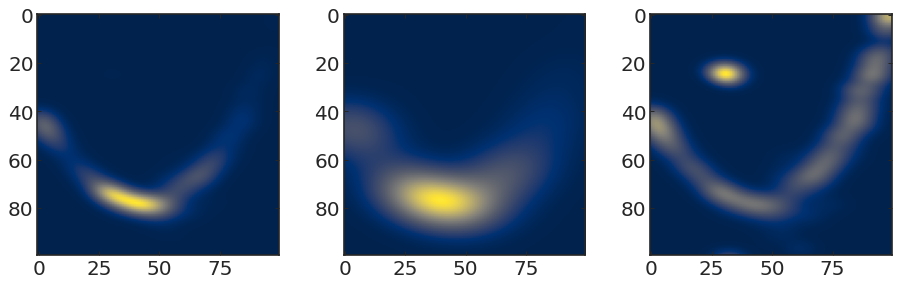

In [220]:
fig, ax=plt.subplots(ncols=3, figsize=(14, 4))
ax[0].imshow(z0, cmap='cividis')
ax[1].imshow(z1, cmap='cividis')
ax[-1].imshow(abs(z0/z1), cmap='cividis')

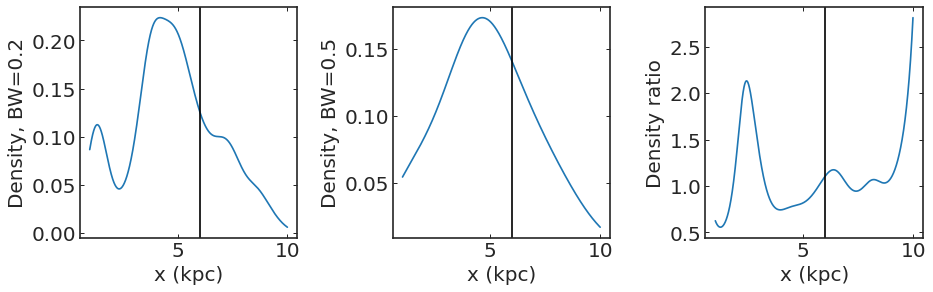

In [17]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
ax[0].plot(X0['grid'], X0['kde'])
ax[1].plot(X1['grid'], X1['kde'])
ax[-1].plot(X1['grid'], X1['kde']/X0['kde'])
for a in ax:
    a.axvline(6, color='k')
    
plt.tight_layout()
ax[0].set(xlabel='x (kpc)', ylabel='Density, BW=0.2')
ax[1].set(xlabel='x (kpc)', ylabel='Density, BW=0.5')
ax[-1].set(xlabel='x (kpc)', ylabel='Density ratio')
plt.tight_layout()

In [18]:
kderatio=X1['kde']/X0['kde']

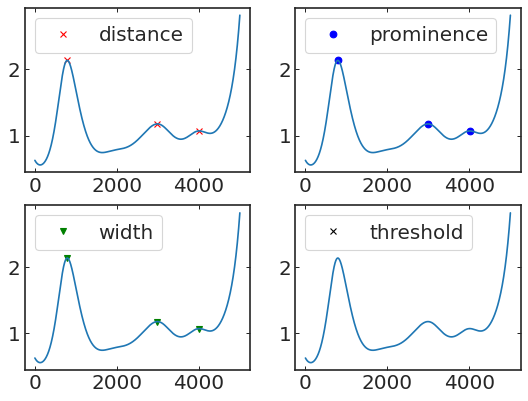

In [19]:
#find peaks
peaks, _ = find_peaks(kderatio, distance=1)
peaks2, res = find_peaks(kderatio, prominence=0.004)      # BEST!
peaks3, _ = find_peaks(kderatio, width=0.01)
peaks4, _ = find_peaks(kderatio, threshold=1.)     # Required vertical distance to its direct neighbouring samples, pretty useless

plt.subplot(2, 2, 1)
plt.plot(peaks, kderatio[peaks], "xr"); plt.plot(kderatio); plt.legend(['distance'])
plt.subplot(2, 2, 2)
plt.plot(peaks2, kderatio[peaks2], "ob"); plt.plot(kderatio); plt.legend(['prominence'])
plt.subplot(2, 2, 3)
plt.plot(peaks3, kderatio[peaks3], "vg"); plt.plot(kderatio); plt.legend(['width'])
plt.subplot(2, 2, 4)
plt.plot(peaks4, kderatio[peaks4], "xk"); plt.plot(kderatio); plt.legend(['threshold'])


In [20]:
res

{'prominences': array([1.38985483, 0.23026642, 0.0369124 ]),
 'left_bases': array([ 130, 1644, 3561]),
 'right_bases': array([1644, 3561, 4270])}

In [21]:
#alernative: march through the grid of points to see which ones are the closest to 1
X1=return_estimated_1d_kernel(x,bw_method=0.6, xmin=x.min(), xmax=x.max())
kl=[]
n_chunks=len(X1['kde'])
#bw_grid=np.logspace(-3, -0.9, 1000)
sm_width=0.2
#for sm_width in tqdm(bw_grid):
X0=return_estimated_1d_kernel(x,bw_method=sm_width, xmin=x.min(), xmax=x.max())
x0=X0['kde']
x1=X1['kde']
#ratios
r=np.exp(-(x0-x1)**2)
kl_sub_array=[]
chunks=np.array_split(r, n_chunks)
for chunck in chunks:
    #compute how much the ratio is different from a line of constants
    kl_sub_array.append(compute_kl_divergence(chunck, np.ones_like(chunck)))
#kl.append(kl_sub_array)


In [22]:
len(kl_sub_array), len(chunks), len(np.nanmean(chunks, axis=1))

(5000, 5000, 5000)

In [23]:
kl_sub_array=np.array(kl_sub_array)

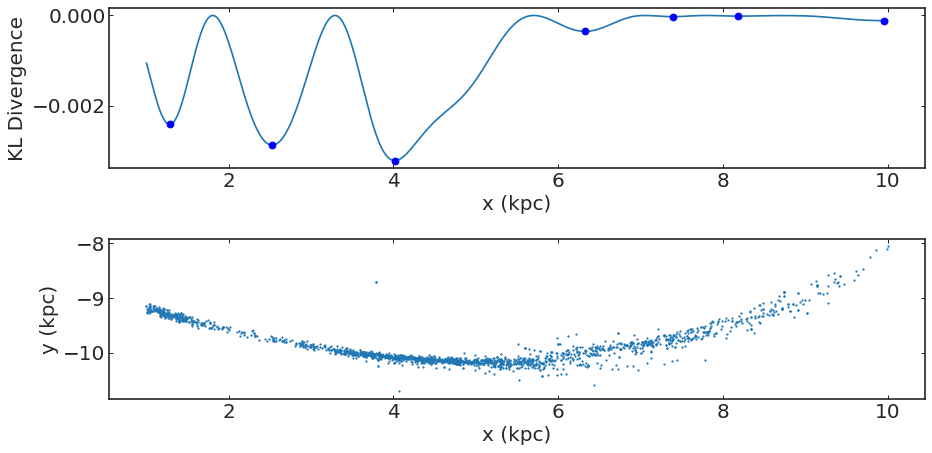

In [24]:
fig, (ax, ax1)=plt.subplots(nrows=2, figsize=(12, 6))
ax.plot(X1['grid'], kl_sub_array)
peaks2, res = find_peaks(1/kl_sub_array, prominence=1e-4)   
ax.plot( X1['grid'][peaks2], kl_sub_array[peaks2], "ob")
ax.set(xlabel= 'x (kpc)', ylabel='KL Divergence')


ax1.scatter(x, y, s=1)
ax1.set(xlabel='x (kpc)', ylabel='y (kpc)')
plt.tight_layout()

In [25]:
res

{'prominences': array([5.37685627e+02, 7.76568711e+07, 1.59416575e+09, 4.15272139e+08,
        7.00807183e+10, 4.07941482e+05, 3.59660007e+01]),
 'left_bases': array([   0,  448,  448, 2612, 3363, 3773, 3773]),
 'right_bases': array([ 448, 1272, 3773, 3773, 3773, 4282, 4999])}

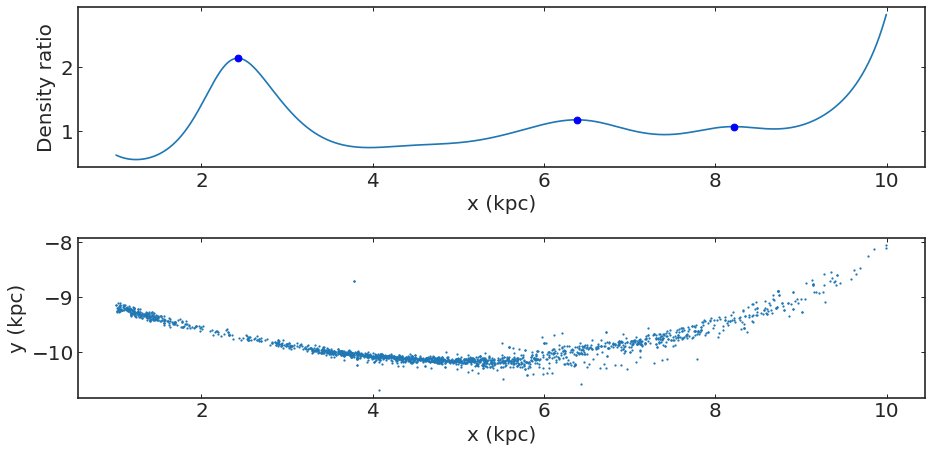

In [26]:
fig, (ax, ax1)=plt.subplots(nrows=2, figsize=(12, 6))
ax.plot(X1['grid'], kderatio)
peaks2, res = find_peaks(kderatio, prominence=1e-4)   
ax.plot( X1['grid'][peaks2], kderatio[peaks2], "ob")
ax.set(xlabel= 'x (kpc)', ylabel='Density ratio')

ax1.scatter(x, y, s=1)
ax1.set(xlabel='x (kpc)', ylabel='y (kpc)')
plt.tight_layout()

In [27]:
res

{'prominences': array([1.38985483, 0.23026642, 0.0369124 ]),
 'left_bases': array([ 130, 1644, 3561]),
 'right_bases': array([1644, 3561, 4270])}

In [134]:
#try adding random backgrounds
x_rand= np.random.uniform(x.min(), x.max(), 1000)
y_rand= np.random.uniform(y.min(), y.max(), 1000)

d= [np.concatenate([x[::2], x_rand]), np.concatenate([y[::2], y_rand])]
X0=return_estimated_1d_kernel(d[0],bw_method=0.2, xmin=x.min(), xmax=x.max())
X1=return_estimated_1d_kernel(d[0],bw_method=0.6, xmin=x.min(), xmax=x.max())
kderatio=X1['kde']/X0['kde']

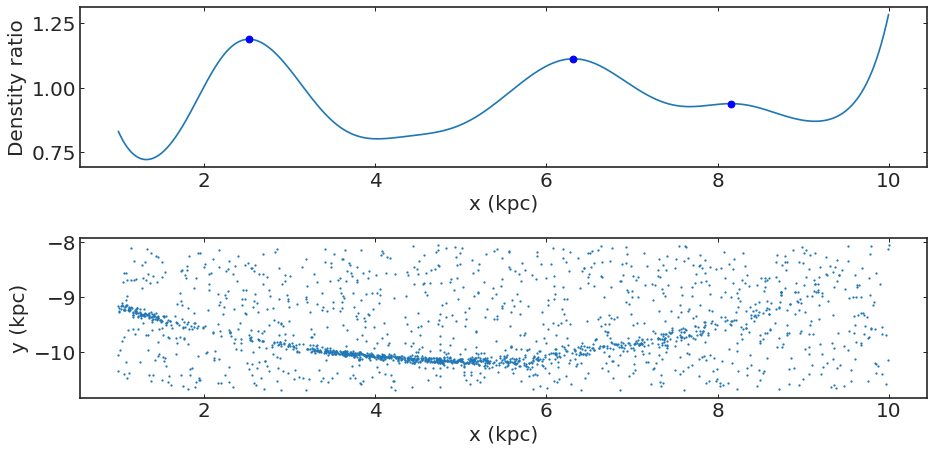

In [29]:
fig, (ax, ax1)=plt.subplots(nrows=2, figsize=(12, 6))
ax.plot(X1['grid'], kderatio)
peaks2, res = find_peaks(kderatio, prominence=1e-4)   
ax.plot( X1['grid'][peaks2], kderatio[peaks2], "ob")
ax.set(xlabel= 'x (kpc)', ylabel='Denstity ratio')


ax1.scatter(d[0], d[1], s=1)
ax1.set(xlabel='x (kpc)', ylabel='y (kpc)')
plt.tight_layout()

In [30]:
res

{'prominences': array([0.38623746, 0.24239018, 0.01153872]),
 'left_bases': array([ 182, 1682, 3709]),
 'right_bases': array([1682, 4522, 4522])}

In [31]:
x0=X0['kde']
x1=X1['kde']
r=np.exp(-(x0-x1)**2)
kl_sub_array=[]
chunks=np.array_split(r, n_chunks)
for chunck in chunks:
    #compute how much the ratio is different from a line of constants
    kl_sub_array.append(compute_kl_divergence(chunck, np.ones_like(chunck)))
#kl.append(kl_sub_array)
kl_sub_array=np.array(kl_sub_array)

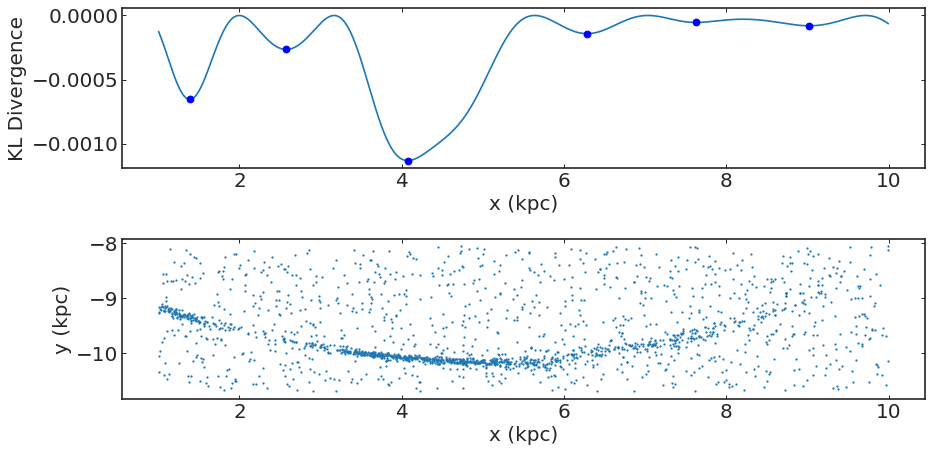

In [32]:
fig, (ax, ax1)=plt.subplots(nrows=2, figsize=(12, 6))
ax.plot(X1['grid'], kl_sub_array)
peaks2, res = find_peaks(1/kl_sub_array, prominence=1e-4)   
ax.plot( X1['grid'][peaks2], kl_sub_array[peaks2], "ob")
ax.set(xlabel= 'x (kpc)', ylabel='KL Divergence')



ax1.scatter(d[0], d[1], s=1)
ax1.set(xlabel='x (kpc)', ylabel='y (kpc)')
plt.tight_layout()

In [33]:
res

{'prominences': array([6.43934667e+03, 1.15422169e+09, 1.71552998e+09, 8.19151334e+09,
        1.59414810e+04, 4.13170378e+09]),
 'left_bases': array([   0,  553,  553, 2576, 3353, 3353]),
 'right_bases': array([ 553, 1203, 4842, 4842, 4006, 4842])}

In [206]:
def march_through_2d(data, nseg=10. , ntries=1000):
    #break down the data into N segements along the x-axis
    x=data[0]
    y=data[-1]
    
    x_grid= np.linspace(x.min(), x.max(), nseg)
    kl_grid=[]

    for idx in range(len(x_grid)):
        kl=0.
        xi=x_grid[idx]
        kls=[]
        if xi > x.min():
            mask = np.logical_and(x>x_grid[idx-1], x<x_grid[idx])
            arr=np.vstack([x[mask], y[mask]])
            
            kls=[]
            
            for n in range(ntries):
            
                unif= np.random.uniform( low=[arr[0].min(), arr[1].min()], high=[arr[0].max(), arr[1].max()],
                                        size= (len(x[mask]), 2)).T

                kls.append(compute_kl_divergence(arr, unif))
            
        kl_grid.append(np.nanmedian(kls))
    
    
    return np.array(x_grid), np.array(kl_grid)
    

In [215]:
kls_2d= march_through_2d(d, nseg=200, ntries=1000)

In [216]:
len(kls_2d[0])

200

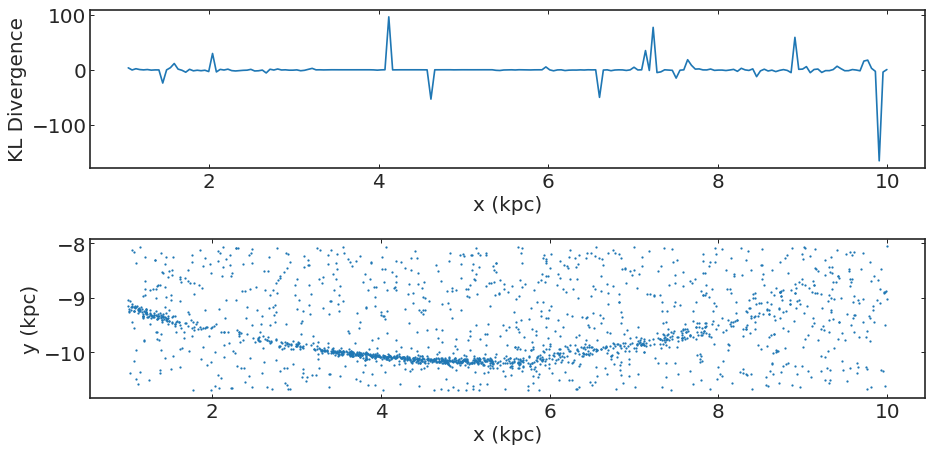

In [218]:
fig, (ax, ax1)=plt.subplots(nrows=2, figsize=(12, 6))
ax.plot(kls_2d[0], 1/kls_2d[-1])
#peaks2, res = find_peaks(1/kl_sub_array, prominence=1e-4)   
#ax.plot( X1['grid'][peaks2], kl_sub_array[peaks2], "ob")
ax.set(xlabel= 'x (kpc)', ylabel='KL Divergence')



ax1.scatter(d[0], d[1], s=1)
ax1.set(xlabel='x (kpc)', ylabel='y (kpc)')
plt.tight_layout()

In [45]:
p=gd.PhaseSpacePosition(pos=[1, 2, 3]*u.kpc, vel=[2, 2, 3]*u.km/u.s)
pi=gd.PhaseSpacePosition(pos=[1, 2, 3]*u.kpc, vel=[2, 2, 3]*u.km/u.s)

In [47]:
px=gd.combine([p, pi])

In [59]:
np.concatenate([px.x, [p.x]])

<Quantity [1., 1., 1.] kpc>